<a href="https://colab.research.google.com/github/pmchhaya/COMP0123/blob/main/COMP0123_CWK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for: Kendrick Lamar
Fetching data for: Drake
Fetching data for: J. Cole
Fetching data for: Nicki Minaj
Rate limit exceeded. Retrying after 2 seconds...
Rate limit exceeded. Retrying after 1 seconds...
Fetching data for: Future
Fetching data for: Cardi B
Rate limit exceeded. Retrying after 1 seconds...
Rate limit exceeded. Retrying after 1 seconds...
Fetching data for: Lil Wayne
Fetching data for: Eminem
Rate limit exceeded. Retrying after 2 seconds...
Rate limit exceeded. Retrying after 1 seconds...
Final network: 500 nodes, 1071 edges
Modularity: 0.685627627957501
Overall Clustering Coefficient: 0.5404188631998331
Node-Level Clustering Coefficients (Sample): {'Kendrick Lamar': 0.028273809523809524, 'SZA': 0.4, 'Dody6': 0, 'Lefty Gunplay': 0, 'Wallie the Sensei': 1.0}
Clustering Coefficient of the Largest Connected Component: 0.5338933703852263


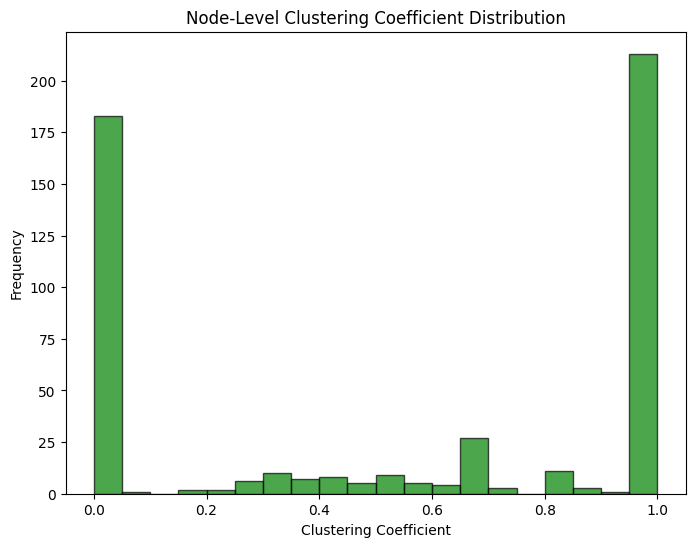

Average Shortest Path Length (Largest Connected Component): 3.0865944359240753
Longest Path Length (Diameter) (Largest Connected Component): 7


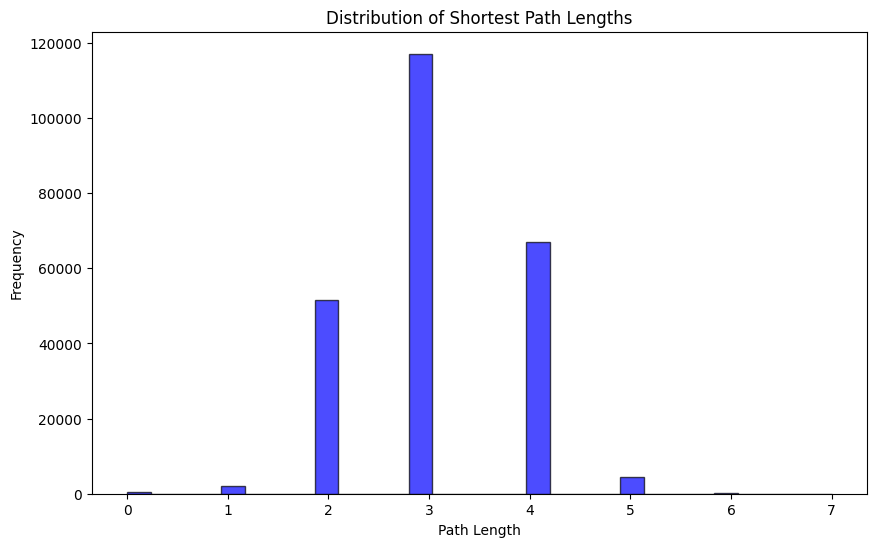

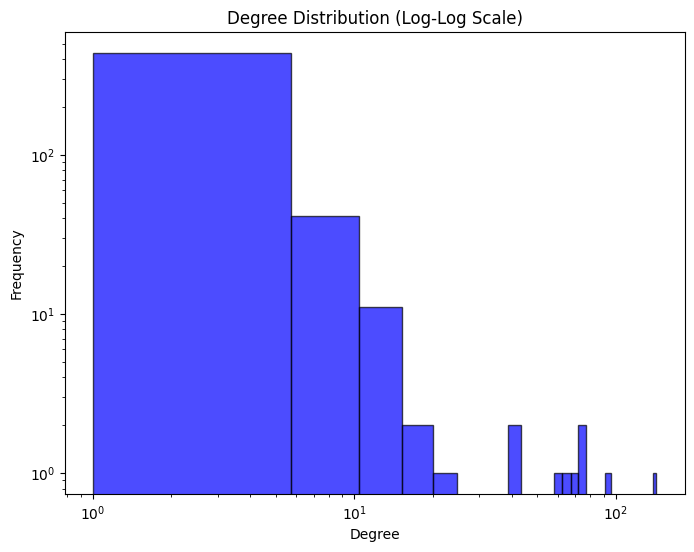

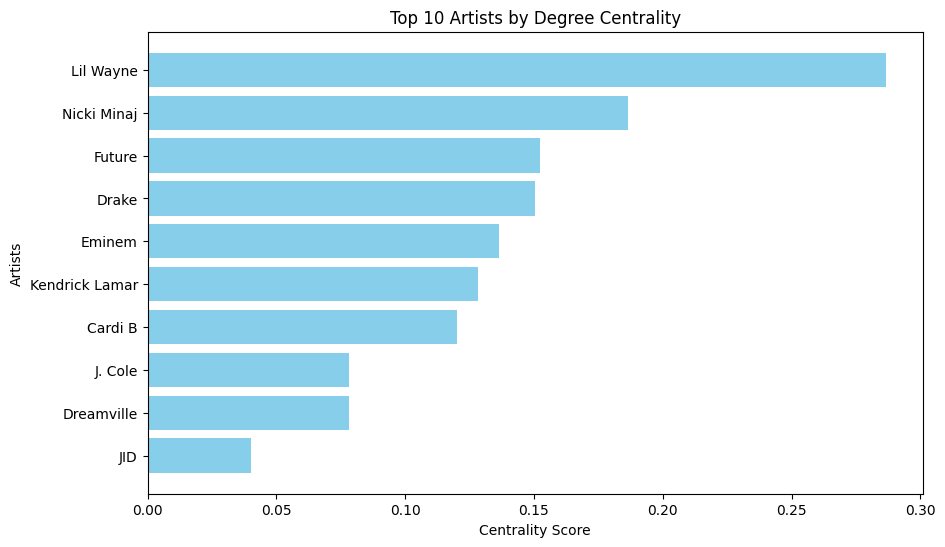

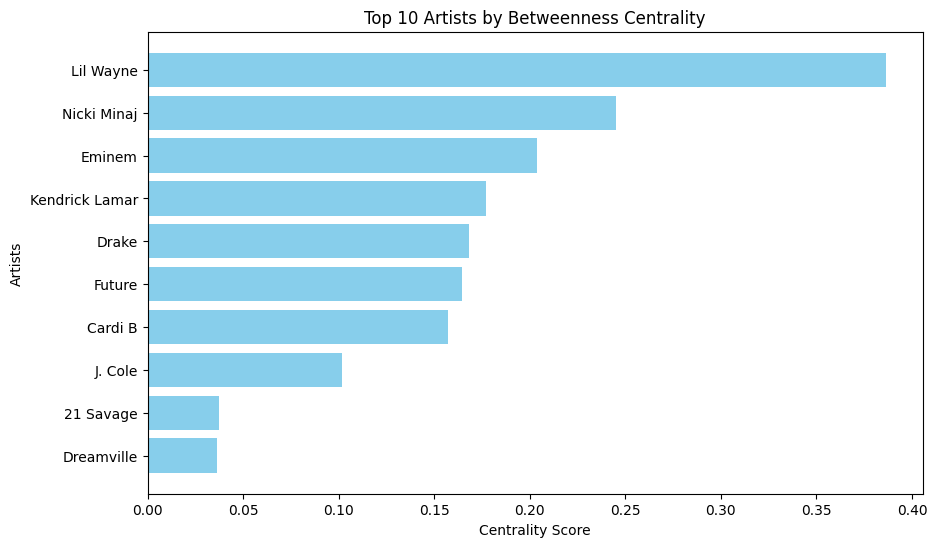

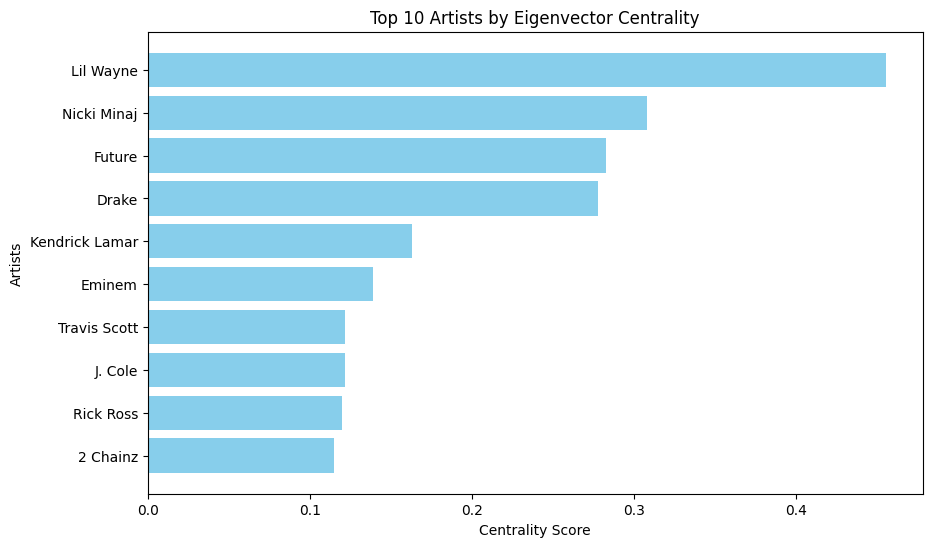

Fetching data for: Kendrick Lamar
Fetching data for: Drake
Fetching data for: J. Cole
Fetching data for: Nicki Minaj
Rate limit exceeded. Retrying after 2 seconds...
Rate limit exceeded. Retrying after 1 seconds...
Fetching data for: Future


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [9]:
import requests
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from community import community_louvain
from collections import Counter
import numpy as np

# Spotify API credentials
CLIENT_ID = '80e9fc548ac94315bed1d9f7dfa715ce'
CLIENT_SECRET = '541580b0d82341da96d38047382350de'

# Step 1: Authenticate with the Spotify API
def get_access_token(client_id, client_secret):
    url = 'https://accounts.spotify.com/api/token'
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    data = {'grant_type': 'client_credentials'}
    response = requests.post(url, headers=headers, data=data, auth=(client_id, client_secret))
    return response.json()['access_token']

ACCESS_TOKEN = get_access_token(CLIENT_ID, CLIENT_SECRET)

# Step 2: Fetch an artist's Spotify ID
import time

def search_artist(artist_name, access_token, retries=3):
    """Search for an artist by name and get their Spotify ID with retry logic."""
    url = f"https://api.spotify.com/v1/search?q={artist_name}&type=artist&limit=1"
    headers = {"Authorization": f"Bearer {access_token}"}

    for attempt in range(retries):
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if 'artists' in data and 'items' in data['artists'] and data['artists']['items']:
                return data['artists']['items'][0]['id']
            else:
                print(f"No artist found for '{artist_name}' or unexpected response format.")
                return None
        elif response.status_code == 429:  # Rate limit exceeded
            retry_after = int(response.headers.get("Retry-After", 1))
            print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
        else:
            print(f"Error fetching artist '{artist_name}': {response.status_code}, {response.text}")
            break

    return None


# Step 3: Fetch collaborations for an artist
def get_artist_collaborations(artist_id, access_token):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/albums?include_groups=album,single&limit=50"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    albums = response.json()

    collaborations = []
    for album in albums.get('items', []):
        album_id = album['id']
        album_url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
        album_response = requests.get(album_url, headers=headers)
        tracks = album_response.json()
        for track in tracks.get('items', []):
            if len(track['artists']) > 1:  # Collaboration detected
                collaborations.append({
                    'track_name': track['name'],
                    'artist1': track['artists'][0]['name'],
                    'artist2': [artist['name'] for artist in track['artists'][1:]],
                    'release_date': album['release_date']
                })
    return collaborations

# Step 4: Build dataset
def build_dataset(seed_artist_name, access_token):
    """Create a DataFrame of collaborations starting with a seed artist."""
    seed_artist_id = search_artist(seed_artist_name, access_token)
    if not seed_artist_id:
        print(f"Seed artist '{seed_artist_name}' not found.")
        return pd.DataFrame()

    collaboration_data = get_artist_collaborations(seed_artist_id, access_token)
    data = pd.DataFrame([
        {'artist1': collab['artist1'], 'artist2': collab['artist2'], 'release_date': collab['release_date']}
        for collab in collaboration_data
    ])
    return data

# Step 5: Expand dataset to ensure 500 nodes
def build_combined_dataset(seed_artists, access_token):
    """Fetch collaborations for multiple seed artists."""
    combined_data = pd.DataFrame()
    for artist in seed_artists:
        print(f"Fetching data for: {artist}")
        artist_data = build_dataset(artist, access_token)
        combined_data = pd.concat([combined_data, artist_data], ignore_index=True)
    return combined_data

def build_collaboration_network_with_limit(data, node_limit=500):
    """Build a network with a node limit."""
    G = nx.Graph()
    for _, row in data.iterrows():
        all_artists = [row['artist1']] + row['artist2']
        for i in range(len(all_artists)):
            for j in range(i + 1, len(all_artists)):
                G.add_edge(all_artists[i], all_artists[j])
        if G.number_of_nodes() >= node_limit:
            break  # Stop adding edges once node limit is reached
    return G

def expand_graph_to_limit(seed_artists, access_token, node_limit=500):
    """Expand the graph dynamically until it has at least `node_limit` nodes."""
    data = build_combined_dataset(seed_artists, access_token)
    G = build_collaboration_network_with_limit(data, node_limit=node_limit)

    # If the node count is still less than the limit, expand further by fetching second-level data
    if G.number_of_nodes() < node_limit:
        additional_data = pd.DataFrame()
        for node in list(G.nodes):
            print(f"Fetching data for second-level artist: {node}")
            node_data = build_dataset(node, access_token)
            additional_data = pd.concat([additional_data, node_data], ignore_index=True)
            G = build_collaboration_network_with_limit(
                pd.concat([data, additional_data], ignore_index=True), node_limit=node_limit
            )
            if G.number_of_nodes() >= node_limit:
                break

    print(f"Final network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Step 6: Community detection
def detect_communities(G):
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    print(f"Modularity: {modularity}")
    return partition

# Step 7: Degree distribution
def plot_degree_distribution(G):
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title("Degree Distribution (Log-Log Scale)")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

# Step 8: Centrality measures
def plot_centrality_comparison(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    metrics = {
        'Degree Centrality': degree_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Eigenvector Centrality': eigenvector_centrality
    }

    for metric_name, centrality in metrics.items():
        top_artists = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
        artists, values = zip(*top_artists)

        plt.figure(figsize=(10, 6))
        plt.barh(artists, values, color='skyblue')
        plt.gca().invert_yaxis()  # Highest at the top
        plt.title(f"Top 10 Artists by {metric_name}")
        plt.xlabel("Centrality Score")
        plt.ylabel("Artists")
        plt.show()

# Step 9: Temporal heatmap
def plot_temporal_heatmap(data):
    data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
    data = data.dropna(subset=['release_date'])
    data['year'] = data['release_date'].dt.year

    yearly_counts = data.groupby('year').size()

    plt.figure(figsize=(10, 6))
    plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue')
    plt.title("Collaborations Over Time")
    plt.xlabel("Year")
    plt.ylabel("Number of Collaborations")
    plt.xticks(rotation=45)
    plt.show()

# Step 10: Network resilience
def plot_resilience_analysis(G):
    original_components = nx.number_connected_components(G)

    high_degree_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]

    fragments = [original_components]
    G_copy = G.copy()
    for node, _ in high_degree_nodes:
        G_copy.remove_node(node)
        fragments.append(nx.number_connected_components(G_copy))

    x_labels = ["Initial"] + [f"Remove {i+1}" for i in range(len(high_degree_nodes))]

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(fragments)), fragments, marker='o', color='red', label="Number of Components")
    plt.title("Resilience Analysis: Effect of Node Removal")
    plt.xlabel("Steps (Nodes Removed)")
    plt.ylabel("Number of Connected Components")
    plt.xticks(range(len(fragments)), x_labels, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Step 11: Run analysis
seed_artists = ["Kendrick Lamar", "Drake", "J. Cole", "Nicki Minaj", "Future", "Cardi B", "Lil Wayne", "Eminem"]
G = expand_graph_to_limit(seed_artists, ACCESS_TOKEN, node_limit=500)

partition = detect_communities(G)

# Step 12: Calculate clustering coefficient
def calculate_clustering_coefficient(G):
    """Calculate and print clustering coefficients."""
    # Overall average clustering coefficient
    overall_clustering = nx.average_clustering(G)
    print(f"Overall Clustering Coefficient: {overall_clustering}")

    # Node-level clustering coefficients
    node_clustering = nx.clustering(G)
    print(f"Node-Level Clustering Coefficients (Sample): {dict(list(node_clustering.items())[:5])}")

    # Clustering coefficient for the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()
    lcc_clustering = nx.average_clustering(G_lcc)
    print(f"Clustering Coefficient of the Largest Connected Component: {lcc_clustering}")

    # Optional: Plot distribution of node-level clustering coefficients
    plt.figure(figsize=(8, 6))
    plt.hist(node_clustering.values(), bins=20, color='green', alpha=0.7, edgecolor='black')
    plt.title("Node-Level Clustering Coefficient Distribution")
    plt.xlabel("Clustering Coefficient")
    plt.ylabel("Frequency")
    plt.show()
# Step 13: Clustering coefficient analysis
calculate_clustering_coefficient(G)

# Step 13: Calculate average shortest and longest path lengths
def calculate_path_lengths(G):
    """Calculate and print average shortest and longest path lengths for the largest connected component."""
    # Extract the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

    # Average shortest path length
    avg_shortest_path_length = nx.average_shortest_path_length(G_lcc)
    print(f"Average Shortest Path Length (Largest Connected Component): {avg_shortest_path_length}")

    # Longest path in the graph (diameter)
    diameter = nx.diameter(G_lcc)
    print(f"Longest Path Length (Diameter) (Largest Connected Component): {diameter}")

    # Optional: Histogram of shortest path lengths
    lengths = dict(nx.shortest_path_length(G_lcc))
    all_lengths = []
    for source, targets in lengths.items():
        all_lengths.extend(targets.values())

    plt.figure(figsize=(10, 6))
    plt.hist(all_lengths, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title("Distribution of Shortest Path Lengths")
    plt.xlabel("Path Length")
    plt.ylabel("Frequency")
    plt.show()

# Step 14: Path length analysis
calculate_path_lengths(G)



# Plots
plot_degree_distribution(G)
plot_centrality_comparison(G)
data = build_combined_dataset(seed_artists, ACCESS_TOKEN)  # For temporal heatmap
plot_temporal_heatmap(data)
plot_resilience_analysis(G)


Rate limit exceeded. Retrying after 1 seconds...
Rate limit exceeded. Retrying after 1 seconds...
Modularity: 0.6376225642516927


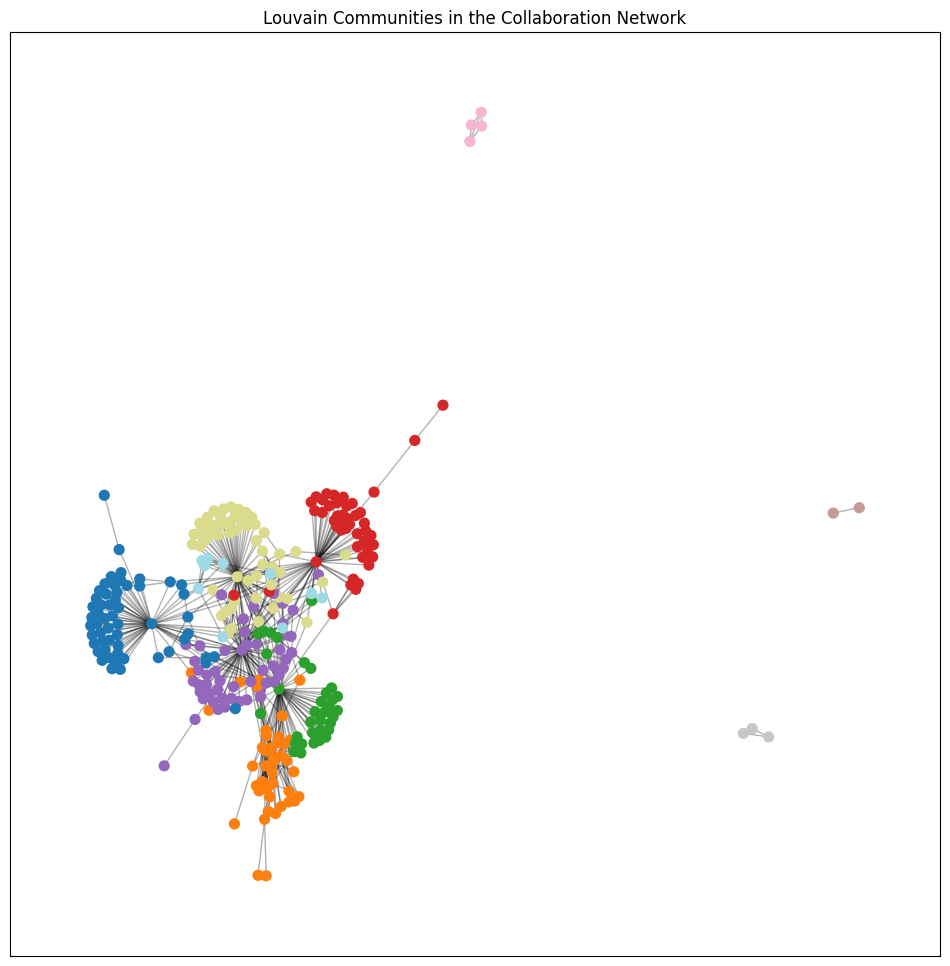

Rate limit exceeded. Retrying after 1 seconds...
Rate limit exceeded. Retrying after 1 seconds...
Rate limit exceeded. Retrying after 1 seconds...
Community 0:
  97: 1
  71: 2
  78: 2
  70: 3
  80: 2
  66: 4
  68: 1
  69: 2
  60: 1
  48: 1
  82: 1
  65: 1
  83: 2
  51: 1
  49: 1
  53: 1
  63: 3
  79: 2
  73: 2
  42: 1
  59: 1
  72: 1
  58: 2
  86: 1
  54: 2
  62: 2
  85: 1
  37: 2
  57: 2
  39: 1
  38: 2
  46: 1
  77: 1
  55: 1
  21: 1
  40: 1
Community 4:
  96: 1
  97: 2
  72: 2
  83: 3
  86: 1
  78: 3
  82: 1
  67: 7
  89: 2
  81: 3
  41: 1
  62: 1
  66: 1
  74: 1
  57: 1
  51: 1
  69: 3
  48: 1
  64: 1
  68: 1
  77: 1
  65: 2
  71: 1
  63: 3
  70: 2
  60: 1
  56: 1
  49: 1
  73: 1
  40: 1
Community 1:
  77: 2
  50: 3
  70: 1
  38: 1
  64: 4
  61: 1
  52: 3
  84: 1
  78: 1
  53: 3
  63: 1
  66: 2
  79: 1
  62: 1
  72: 1
  57: 2
  56: 1
  71: 1
  80: 1
  45: 1
  67: 1
  59: 1
  35: 2
  73: 2
  Unknown: 1
  58: 1
  42: 1
  33: 1
Community 3:
  86: 1
  81: 1
  92: 1
  93: 2
  88: 2
  67

In [7]:
import requests
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from community import community_louvain
import numpy as np
import time

# Spotify API credentials
CLIENT_ID = '80e9fc548ac94315bed1d9f7dfa715ce'
CLIENT_SECRET = '541580b0d82341da96d38047382350de'

# Step 1: Authenticate with the Spotify API
def get_access_token(client_id, client_secret):
    url = 'https://accounts.spotify.com/api/token'
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    data = {'grant_type': 'client_credentials'}
    response = requests.post(url, headers=headers, data=data, auth=(client_id, client_secret))
    return response.json()['access_token']

ACCESS_TOKEN = get_access_token(CLIENT_ID, CLIENT_SECRET)

# Step 2: Fetch an artist's Spotify ID
def search_artist(artist_name, access_token, retries=3):
    url = f"https://api.spotify.com/v1/search?q={artist_name}&type=artist&limit=1"
    headers = {"Authorization": f"Bearer {access_token}"}

    for attempt in range(retries):
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if 'artists' in data and 'items' in data['artists'] and data['artists']['items']:
                return data['artists']['items'][0]['id']
            else:
                print(f"No artist found for '{artist_name}' or unexpected response format.")
                return None
        elif response.status_code == 429:  # Rate limit exceeded
            retry_after = int(response.headers.get("Retry-After", 1))
            print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
        else:
            print(f"Error fetching artist '{artist_name}': {response.status_code}, {response.text}")
            break

    return None

# Step 3: Fetch artist's geographic attributes
def get_artist_geography(artist_id, access_token):
    url = f"https://api.spotify.com/v1/artists/{artist_id}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    data = response.json()

    # Extract geographic information (simplified to country)
    if 'followers' in data and 'genres' in data:
        return {
            'name': data.get('name', ''),
            'country': data.get('popularity', 'Unknown')  # Modify based on API return fields
        }
    return {'name': 'Unknown', 'country': 'Unknown'}

# Step 4: Fetch collaborations for an artist
def get_artist_collaborations(artist_id, access_token):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/albums?include_groups=album,single&limit=50"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(url, headers=headers)
    albums = response.json()

    collaborations = []
    for album in albums.get('items', []):
        album_id = album['id']
        album_url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
        album_response = requests.get(album_url, headers=headers)
        tracks = album_response.json()
        for track in tracks.get('items', []):
            if len(track['artists']) > 1:  # Collaboration detected
                collaborations.append({
                    'track_name': track['name'],
                    'artist1': track['artists'][0]['name'],
                    'artist2': [artist['name'] for artist in track['artists'][1:]],
                    'release_date': album['release_date']
                })
    return collaborations

# Step 5: Build dataset and graph
def build_dataset(seed_artist_name, access_token):
    """Create a DataFrame of collaborations starting with a seed artist."""
    seed_artist_id = search_artist(seed_artist_name, access_token)
    if not seed_artist_id:
        print(f"Seed artist '{seed_artist_name}' not found.")
        return pd.DataFrame()

    collaboration_data = get_artist_collaborations(seed_artist_id, access_token)
    data = pd.DataFrame([
        {'artist1': collab['artist1'], 'artist2': collab['artist2'], 'release_date': collab['release_date']}
        for collab in collaboration_data
    ])
    return data

def build_collaboration_network(data):
    """Build a collaboration network with nodes and edges."""
    G = nx.Graph()
    for _, row in data.iterrows():
        all_artists = [row['artist1']] + row['artist2']
        for i in range(len(all_artists)):
            for j in range(i + 1, len(all_artists)):
                G.add_edge(all_artists[i], all_artists[j], release_date=row['release_date'])
    return G

# Step 6: Apply Louvain community detection
def detect_communities_and_visualize(G):
    """Detect communities using Louvain and visualize the network."""
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    print(f"Modularity: {modularity}")

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Use spring layout for visualization

    # Color nodes by community
    community_colors = [partition[node] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=community_colors, cmap=plt.cm.tab20)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title("Louvain Communities in the Collaboration Network")
    plt.show()

    return partition

# Step 7: Analyze geographic factors
def analyze_geographic_factors(G, partition, access_token):
    """Assign geographic attributes and analyze their impact on communities."""
    geographic_data = {}
    for node in G.nodes():
        artist_id = search_artist(node, access_token)
        if artist_id:
            geography = get_artist_geography(artist_id, access_token)
            geographic_data[node] = geography.get('country', 'Unknown')
        else:
            geographic_data[node] = 'Unknown'

    # Count the geographic distribution within each community
    community_geography = {}
    for node, community_id in partition.items():
        if community_id not in community_geography:
            community_geography[community_id] = Counter()
        community_geography[community_id][geographic_data[node]] += 1

    # Print geographic analysis results
    for community_id, geography_counts in community_geography.items():
        print(f"Community {community_id}:")
        for country, count in geography_counts.items():
            print(f"  {country}: {count}")

# Step 8: Run the analysis
seed_artists = ["Kendrick Lamar", "Drake", "J. Cole", "Nicki Minaj", "Future"]
data = pd.concat([build_dataset(artist, ACCESS_TOKEN) for artist in seed_artists], ignore_index=True)
G = build_collaboration_network(data)

# Detect communities and visualize
partition = detect_communities_and_visualize(G)

# Analyze geographic factors
analyze_geographic_factors(G, partition, ACCESS_TOKEN)
